In [1]:
## Lesson 3 CamVid Tiramisu
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
#import matplotlib.pyplot as plt

path = Path('/mnt/c/School/Scripts/TestData/')

In [2]:
from fastai.utils.show_install import *
show_install()



```text
=== Software === 
python       : 3.7.1
fastai       : 1.0.51
fastprogress : 0.1.20
torch        : 1.0.1.post2
torch cuda   : 10.0.130 / is **Not available** 

=== Hardware === 
No GPUs available 

=== Environment === 
platform     : Linux-4.4.0-17134-Microsoft-x86_64-with-debian-buster-sid
distro       : #523-Microsoft Mon Dec 31 17:49:00 PST 2018
conda env    : Unknown
python       : /home/thor/anaconda3/bin/python
sys.path     : /mnt/c/School/Scripts
/home/thor/anaconda3/lib/python37.zip
/home/thor/anaconda3/lib/python3.7
/home/thor/anaconda3/lib/python3.7/lib-dynload

/home/thor/anaconda3/lib/python3.7/site-packages
/home/thor/anaconda3/lib/python3.7/site-packages/IPython/extensions
/home/thor/.ipython
no supported gpus found on this system
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once

In [3]:
path.ls()

[PosixPath('/mnt/c/School/Scripts/TestData/codes.txt'),
 PosixPath('/mnt/c/School/Scripts/TestData/images'),
 PosixPath('/mnt/c/School/Scripts/TestData/masks'),
 PosixPath('/mnt/c/School/Scripts/TestData/models'),
 PosixPath('/mnt/c/School/Scripts/TestData/valid.txt')]

In [4]:
path_lbl = path/'masks'
path_img = path/'images'

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/mnt/c/School/Scripts/TestData/images/MAGNA_24_86.4671CL_3.19876kg.tif'),
 PosixPath('/mnt/c/School/Scripts/TestData/images/MAGNA_25_83.5527CL_3.51574kg.tif'),
 PosixPath('/mnt/c/School/Scripts/TestData/images/MAGNA_26_87.3007CL_3.58066kg.tif')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/mnt/c/School/Scripts/TestData/masks/MAGNA_24_86.4671CL_3.19876kg.tif'),
 PosixPath('/mnt/c/School/Scripts/TestData/masks/MAGNA_25_83.5527CL_3.51574kg.tif'),
 PosixPath('/mnt/c/School/Scripts/TestData/masks/MAGNA_26_87.3007CL_3.58066kg.tif')]

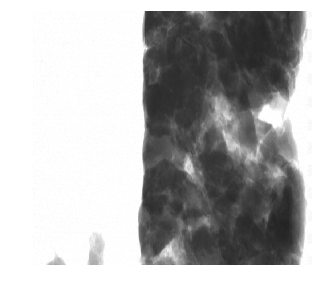

In [7]:
## Data

img_f = fnames[10]
img = open_image(img_f)
img.show(figsize=(5,5))
#plt.show()

In [8]:
img_f.parent.parent

PosixPath('/mnt/c/School/Scripts/TestData')

/mnt/c/School/Scripts/TestData/images
[700 768] tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])


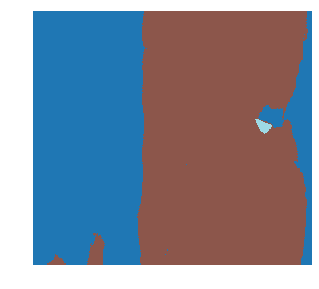

In [9]:
# TODO Continue from here...
def get_y_fn(x):
    print(str(x.parent))
    return Path(str(x.parent.parent)+'/masks') / x.name

codes = array(['Belt', 'Meat', 'Bone', 'Metal'])

mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)
#plt.show()

src_size = np.array(mask.shape[1:])
print(src_size, mask.data)

In [10]:
## Datasets
bs,size = 4,src_size//2

src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('/mnt/c/School/Scripts/TestData/valid.txt')
       .label_from_func(get_y_fn, classes=codes))
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/School/Scripts/TestData/images
/mnt/c/Schoo

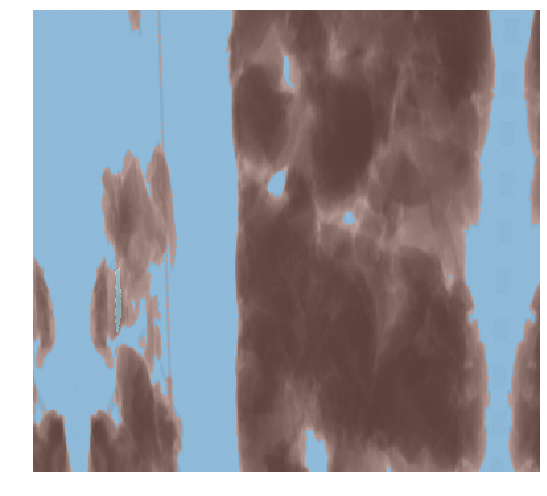

In [11]:
data.show_batch(1, figsize=(10,7))

In [12]:
name2id = {v:k for k,v in enumerate(codes)}

def error_measure(input, target):
    target = target.squeeze(1)
    mask_isVoid = target != name2id['Belt']
    mask_isBone = target == name2id['Bone']
    mask_ismetal = target == name2id['Metal']
    
    error = (input.argmax(dim=1)[mask_isVoid]!=target[mask_isVoid]).float().mean()
    boneError = input.argmax(dim=1)[mask_isBone]!=target[mask_isBone]
    metalError = input.argmax(dim=1)[mask_ismetal]!=target[mask_ismetal]
    if len(boneError) != 0:
        error += 10*boneError.float().mean()
    if len(metalError) != 0:
        error += 100*metalError.float().mean()
    
    return error

In [13]:
metrics = error_measure

In [14]:
wd=1e-2

In [15]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [16]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [16]:
lr=1e-4

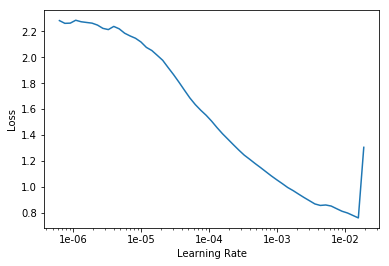

In [17]:
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,error_measure,time
0,2.447192,1.670489,53.397850,04:51
1,1.666173,0.372570,105.247055,05:00
2,1.042463,0.130842,105.010437,04:42
3,0.726528,0.046978,105.017609,04:41
4,0.509982,0.033573,105.031990,04:36
5,0.369184,0.023960,105.015503,04:41
6,0.276833,0.019737,105.025063,04:40
7,0.210668,0.018183,105.028679,04:38
8,0.168512,0.029746,105.001892,04:40
9,0.133680,0.016989,105.010223,04:38


In [18]:
learn.save('stage-1-big')

In [19]:
learn.load('stage-1-big');

In [20]:
learn.unfreeze()

In [21]:
lrs = slice(1e-6,lr/10)

In [22]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,error_measure,time
0,0.041372,0.016255,105.011093,04:44
1,0.039047,0.014881,105.012451,04:45
2,0.039695,0.015318,105.006088,04:46
3,0.042081,0.015572,105.004776,04:45
4,0.040405,0.013912,105.006096,04:47
5,0.037230,0.012652,105.013596,04:45
6,0.034827,0.012207,105.011726,04:49
7,0.033859,0.012192,105.009567,04:46
8,0.033050,0.011976,105.011917,04:46
9,0.032119,0.011935,105.011978,04:46


In [23]:
learn.save('stage-2-big')

In [24]:
learn.load('stage-2-big');

In [74]:
#learn.show_results(rows=8, figsize=(20,20)) # This shows incorrect predictions?

In [31]:
preds,y = learn.get_preds()

In [72]:
def getContanimentInfo(prediction):
    items = prediction.unique()
    
    name2id = {v:k for k,v in enumerate(codes)}
    if name2id['Bone'] in items and name2id['Metal'] in items:
        return "Bone and Metal"
    if name2id['Metal'] in items:
        return "Metal"
    if name2id['Bone'] in items:
        return "Bone"
    if name2id['Meat'] in items:
        return "just Meat"
    else:
        return "Nothing"

########################
Ground truth/Predictions
########################
There is Metal. Found just Meat.


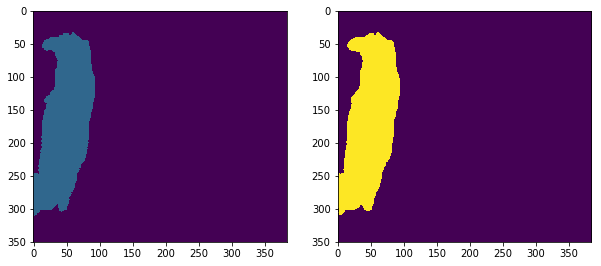

There is Metal. Found just Meat.


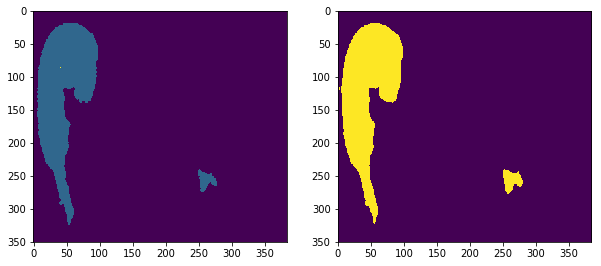

There is Metal. Found just Meat.


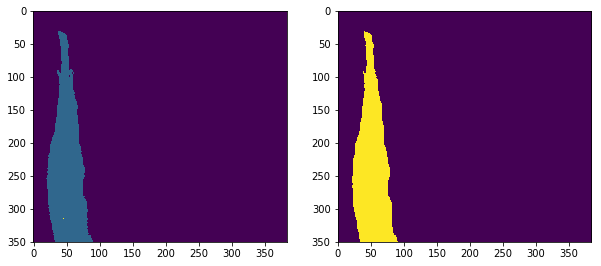

There is Metal. Found just Meat.


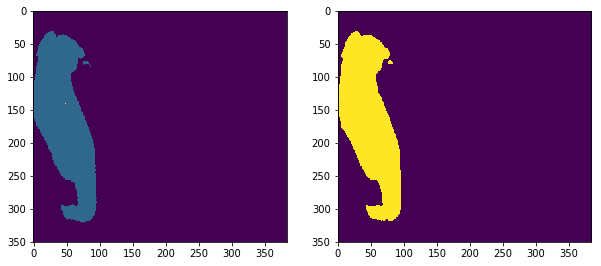

There is Metal. Found just Meat.


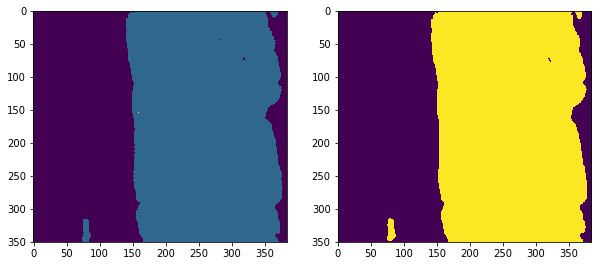

There is Bone. Found just Meat.


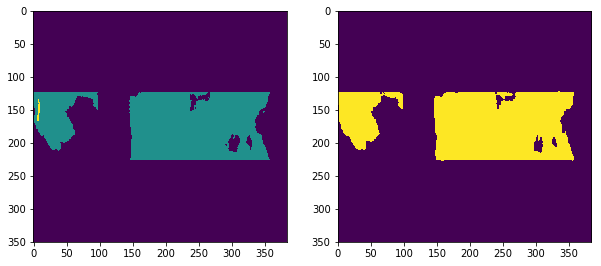

There is Bone. Found just Meat.


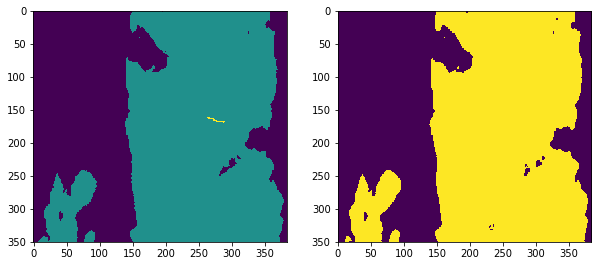

There is Bone. Found just Meat.


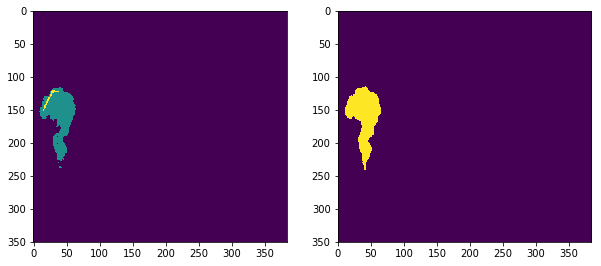

In [73]:
y = torch.squeeze(y)
print("########################")
print("Ground truth/Predictions")
print("########################")
for i in range(8):
    prediction = preds.argmax(dim=1)[i]
    print("There is {}. Found {}.".format(getContanimentInfo(y[i]), getContanimentInfo(prediction)))
    fig=plt.figure(figsize=(10,20))
    fig.add_subplot(1, 2, 1)
    plt.imshow(y[i])
    fig.add_subplot(1, 2, 2)
    plt.imshow(prediction)
    plt.show()
    